# 🧠 Brain Tumor Segmentation Using 3D U-Net and Attention U-Net (PyTorch)
### Advanced Deep Learning Pipeline for MRI Segmentation

This notebook presents a complete deep learning pipeline for 3D brain tumor segmentation from MRI images using U-Net and Attention U-Net architectures.

**Features:**
- Data preprocessing and loading for multi-modal MRI
- Custom PyTorch dataset and data loader
- Implementation of U-Net and Attention U-Net
- Advanced training loop with early stopping and learning rate scheduling
- Quantitative evaluation (Dice, loss curves) and qualitative visualizations
- Easily adaptable for research, internship, and clinical exploration

----


## ⚙️ Setup and Dependencies

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
import nibabel as nib

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('✅ Using device:', DEVICE)

✅ Using device: cuda


In [2]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ CUDA available:", torch.cuda.is_available())
print("🧠 Device:", DEVICE)


✅ CUDA available: True
🧠 Device: cuda


## 📂 Dataset Loader: Patch-wise, Lazy Loading from `.nii.gz` (BraTS2021)


In [3]:
# BraTS 2023 Patch-based 3D Dataset
# This dataset class loads 3D patches from BraTS patient directories.
import nibabel as nib
import torch
import numpy as np
from torch.utils.data import Dataset
import os, random

class BraTSPatch3DDataset(Dataset):
    def __init__(self, patient_dirs, patch_depth=64, augment=False):
        self.patch_depth = patch_depth
        self.augment = augment
        self.patients = []       # Preloaded patients: (image, seg)
        self.patch_index = []    # List of (patient_idx, z_start)

        for i, p in enumerate(patient_dirs):
            pid = os.path.basename(p)

            def load_modality(name):
                path = os.path.join(p, f"{pid}_{name}.nii.gz")
                return nib.load(path).get_fdata(dtype=np.float32)

            # Load and normalize once
            flair = load_modality("flair")
            t1 = load_modality("t1")
            t1ce = load_modality("t1ce")
            t2 = load_modality("t2")
            seg = load_modality("seg")

            image = np.stack([flair, t1, t1ce, t2], axis=0)  # Shape: (4, H, W, D)
            for c in range(4):
                img = image[c]
                image[c] = (img - np.mean(img)) / (np.std(img) + 1e-5)

            self.patients.append((image, seg))

            # Create patch indices
            depth = image.shape[-1]
            for z in range(0, depth - patch_depth, patch_depth // 2):
                self.patch_index.append((i, z))

    def __len__(self):
        return len(self.patch_index)

    def __getitem__(self, idx):
        patient_idx, z = self.patch_index[idx]
        image, seg = self.patients[patient_idx]

        patch_img = image[:, :, :, z:z+self.patch_depth]
        patch_seg = seg[:, :, z:z+self.patch_depth]

        patch_img = torch.tensor(patch_img.copy(), dtype=torch.float32)
        patch_seg = torch.tensor(patch_seg.copy(), dtype=torch.long)

        if self.augment and random.random() > 0.5:
            patch_img = torch.flip(patch_img, dims=[3])
            patch_seg = torch.flip(patch_seg, dims=[2])

        return patch_img, patch_seg


## 🔀 Dataset Split: Train & Validation
We use an 80/20 split to train and evaluate performance.

In [4]:
# Set your BraTS2021 root directory
root_dir = r"C:\Users\amira\Downloads\BraTS2021_Training_Data"

# Gather patient directories
patient_dirs = sorted([
    os.path.join(root_dir, d)
    for d in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, d))
])
random.shuffle(patient_dirs)  # Shuffle for randomness

# Patient-level 80/20 split to avoid data leakage
split_idx = int(0.8 * len(patient_dirs))
train_patients = patient_dirs[:split_idx]
val_patients = patient_dirs[split_idx:]

# Initialize datasets

class BraTSPatch3DDataset(Dataset):
    def __init__(self, patient_dirs, patch_depth=64, augment=False):
        self.patient_dirs = patient_dirs
        self.patch_depth = patch_depth
        self.augment = augment
        self.patch_index = []  # Stores (patient_index, z_start)

        # Build patch index only for tumor-containing patches
        for i, p in enumerate(patient_dirs):
            seg_path = os.path.join(p, os.path.basename(p) + '_seg.nii.gz')
            seg = nib.load(seg_path).get_fdata()
            depth = seg.shape[-1]

            for z in range(0, depth - patch_depth, patch_depth // 2):
                patch = seg[:, :, z:z+patch_depth]
                if np.max(patch) > 0:  # ✅ Skip background-only patches
                    self.patch_index.append((i, z))

    def __len__(self):
        return len(self.patch_index)

    def __getitem__(self, idx):
        patient_idx, z = self.patch_index[idx]
        p = self.patient_dirs[patient_idx]
        pid = os.path.basename(p)

        def load_modality(name):
            path = os.path.join(p, f"{pid}_{name}.nii.gz")
            return nib.load(path).get_fdata(dtype=np.float32)

        # Load 4 MRI modalities
        flair = load_modality("flair")
        t1 = load_modality("t1")
        t1ce = load_modality("t1ce")
        t2 = load_modality("t2")
        seg = load_modality("seg")

        # Extract 3D patch: (C, H, W, D)
        image = np.stack([flair, t1, t1ce, t2], axis=0)[:, :, :, z:z+self.patch_depth]
        mask = seg[:, :, z:z+self.patch_depth]

        # Normalize each channel independently
        for i in range(4):
            img = image[i]
            image[i] = (img - np.mean(img)) / (np.std(img) + 1e-5)

        # Convert to tensors
        image = torch.tensor(image.copy(), dtype=torch.float32)
        mask = torch.tensor(mask.copy(), dtype=torch.long)

        # Optional horizontal flip
        if self.augment and random.random() > 0.5:
            image = torch.flip(image, dims=[3])  # flip in depth
            mask = torch.flip(mask, dims=[2])

        return image, mask

train_dataset = BraTSPatch3DDataset(train_patients, patch_depth=32, augment=True)
val_dataset = BraTSPatch3DDataset(val_patients, patch_depth=32, augment=False)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

# Display info
print("✅ Dataset loaded successfully")
print("Train patients:", len(train_patients))
print("Val patients:", len(val_patients))
print("Train samples (patches):", len(train_dataset))
print("Val samples (patches):", len(val_dataset))


✅ Dataset loaded successfully
Train patients: 1000
Val patients: 251
Train samples (patches): 5741
Val samples (patches): 1425


## 🧠 U-Net 3D and Attention U-Net3D Architectures

In [5]:
import torch.nn as nn

class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=3):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True)
            )
        self.enc1 = block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.bottleneck = block(64, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, 2)
        self.dec2 = block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, 2)
        self.dec1 = block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out_conv(d1)

class AttentionBlock3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv3d(F_g, F_int, 1), nn.BatchNorm3d(F_int))
        self.W_x = nn.Sequential(nn.Conv3d(F_l, F_int, 1), nn.BatchNorm3d(F_int))
        self.psi = nn.Sequential(nn.Conv3d(F_int, 1, 1), nn.BatchNorm3d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        return x * self.psi(self.relu(self.W_g(g) + self.W_x(x)))

class AttentionUNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=3):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True)
            )
        self.enc1 = block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.bottleneck = block(64, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, 2)
        self.att2 = AttentionBlock3D(64, 64, 32)
        self.dec2 = block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, 2)
        self.att1 = AttentionBlock3D(32, 32, 16)
        self.dec1 = block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.att2(self.up2(b), e2)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.att1(self.up1(d2), e1)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return self.out_conv(d1)


## 🧪 Training loop Function (AMP + EarlyStopping + Dice Score)

In [10]:

from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time

def dice_coeff(pred, target, eps=1e-6):
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred == target).float().sum()
    return (2. * intersection) / (pred.numel() + target.numel() + eps)

def train_model(model, train_loader, val_loader, name, epochs=100):
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    criterion = torch.nn.CrossEntropyLoss()
    scaler = GradScaler()
    best_dice = 0
    patience = 10
    trigger = 0
    val_dices = []

    print(f"\n⏳ Measuring first batch load time...")
    t0 = time.time()
    _ = next(iter(train_loader))
    print(f"✅ First batch loaded in {time.time() - t0:.2f} seconds.\n")

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0

        print(f"\n🔁 Epoch {epoch}/{epochs}")
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()

            with autocast():
                out = model(x)
                # Ensure labels are within valid range
                y = torch.clamp(y, 0, out.shape[1] - 1)
                loss = criterion(out, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

            # Batch progress logging
            if i % 100 == 0:
                print(f"   ↪ Batch {i}/{len(train_loader)} | Loss: {loss.item():.4f}")

        # Validation
        model.eval()
        dice = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                with autocast():
                    pred = torch.argmax(model(x), dim=1)
                dice += dice_coeff(pred.cpu(), y.cpu())

        avg_dice = dice / len(val_loader)
        val_dices.append(avg_dice.item())
        print(f"✅ Epoch {epoch} complete | Loss: {total_loss:.4f} | Val Dice: {avg_dice:.4f}")
        scheduler.step(total_loss)

        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), f"{name}_best.pth")
            print(f"💾 Best model saved with Dice: {best_dice:.4f}")
            trigger = 0
        else:
            trigger += 1
            print(f"⚠️ No improvement. Patience: {trigger}/{patience}")
            if trigger >= patience:
                print("⏹️ Early stopping triggered.")
                break

    # Plot Dice over epochs
    plt.figure(figsize=(8, 4))
    plt.plot(val_dices, label="Validation Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Score")
    plt.title(f"Dice Curve for {name}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
labels = []
for _, y in train_loader:
    labels.append(y.max().item())
    break

print("Max label value in dataset:", max(labels))


Max label value in dataset: 4



⏳ Measuring first batch load time...
✅ First batch loaded in 0.34 seconds.


🔁 Epoch 1/100
   ↪ Batch 0/5741 | Loss: 1.2150
   ↪ Batch 100/5741 | Loss: 0.7321
   ↪ Batch 200/5741 | Loss: 0.6350
   ↪ Batch 300/5741 | Loss: 0.4842
   ↪ Batch 400/5741 | Loss: 0.3879
   ↪ Batch 500/5741 | Loss: 0.3242
   ↪ Batch 600/5741 | Loss: 0.2751
   ↪ Batch 700/5741 | Loss: 0.2488
   ↪ Batch 800/5741 | Loss: 0.1906
   ↪ Batch 900/5741 | Loss: 0.1670
   ↪ Batch 1000/5741 | Loss: 0.1460
   ↪ Batch 1100/5741 | Loss: 0.1246
   ↪ Batch 1200/5741 | Loss: 0.1154
   ↪ Batch 1300/5741 | Loss: 0.1065
   ↪ Batch 1400/5741 | Loss: 0.0789
   ↪ Batch 1500/5741 | Loss: 0.1102
   ↪ Batch 1600/5741 | Loss: 0.0640
   ↪ Batch 1700/5741 | Loss: 0.0641
   ↪ Batch 1800/5741 | Loss: 0.0525
   ↪ Batch 1900/5741 | Loss: 0.0449
   ↪ Batch 2000/5741 | Loss: 0.0430
   ↪ Batch 2100/5741 | Loss: 0.0661
   ↪ Batch 2200/5741 | Loss: 0.0327
   ↪ Batch 2300/5741 | Loss: 0.0291
   ↪ Batch 2400/5741 | Loss: 0.0298
   ↪ Batch 2500/5741

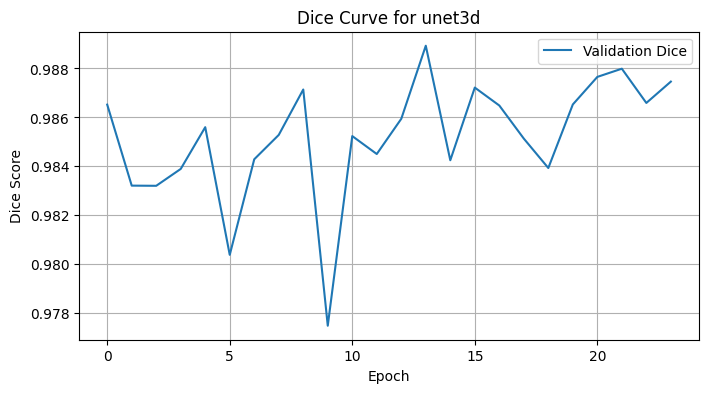

In [8]:
unet = UNet3D()
train_model(unet, train_loader, val_loader, name="unet3d")


In [8]:
import torch
import numpy as np
from medpy.metric.binary import hd95
from monai.metrics import DiceMetric

def evaluate_model(model, val_loader, num_classes=4):
    model.eval()
    dices = []
    hd95s = [[] for _ in range(num_classes)]
    dice_metric = DiceMetric(include_background=True, reduction="none")

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = model(x)
            preds = torch.argmax(preds, dim=1)

            # MONAI Dice expects shape (B, C, ...)
            y_onehot = torch.nn.functional.one_hot(y, num_classes=num_classes).permute(0, 4, 1, 2, 3)
            p_onehot = torch.nn.functional.one_hot(preds, num_classes=num_classes).permute(0, 4, 1, 2, 3)

            dice = dice_metric(p_onehot.float(), y_onehot.float())
            dices.append(dice.cpu().numpy())

            y_np = y.cpu().numpy()
            pred_np = preds.cpu().numpy()

            # Hausdorff (per class, per sample)
            for b in range(pred_np.shape[0]):
                for cls in range(num_classes):
                    gt_bin = (y_np[b] == cls).astype(np.uint8)
                    pred_bin = (pred_np[b] == cls).astype(np.uint8)
                    if np.any(gt_bin) and np.any(pred_bin):
                        hd = hd95(pred_bin, gt_bin)
                        hd95s[cls].append(hd)

    # Final Scores
    dices = np.vstack(dices)
    mean_dice_per_class = np.nanmean(dices, axis=0)

    mean_hd95_per_class = [np.mean(hd) if len(hd) > 0 else np.nan for hd in hd95s]

    print("\n📊 **Per-Class Dice Scores:**")
    for i, d in enumerate(mean_dice_per_class):
        print(f"  Class {i}: Dice = {d:.4f}")

    print("\n📐 **Per-Class Hausdorff 95 Distances (lower is better):**")
    for i, h in enumerate(mean_hd95_per_class):
        print(f"  Class {i}: HD95 = {h:.2f} voxels")

    return mean_dice_per_class, mean_hd95_per_class


In [9]:
for x, y in val_loader:
    print("Label shape:", y.shape)
    print("Label unique values:", torch.unique(y))
    break


Label shape: torch.Size([1, 240, 240, 32])
Label unique values: tensor([0, 1, 2, 4])



⏳ Measuring first batch load time...
✅ First batch loaded in 0.31 seconds.


🔁 Epoch 1/100
   ↪ Batch 0/5741 | Loss: 1.0701
   ↪ Batch 100/5741 | Loss: 0.5815
   ↪ Batch 200/5741 | Loss: 0.4653
   ↪ Batch 300/5741 | Loss: 0.3809
   ↪ Batch 400/5741 | Loss: 0.3556
   ↪ Batch 500/5741 | Loss: 0.3160
   ↪ Batch 600/5741 | Loss: 0.2126
   ↪ Batch 700/5741 | Loss: 0.1837
   ↪ Batch 800/5741 | Loss: 0.1390
   ↪ Batch 900/5741 | Loss: 0.1282
   ↪ Batch 1000/5741 | Loss: 0.1277
   ↪ Batch 1100/5741 | Loss: 0.1010
   ↪ Batch 1200/5741 | Loss: 0.0795
   ↪ Batch 1300/5741 | Loss: 0.0896
   ↪ Batch 1400/5741 | Loss: 0.0651
   ↪ Batch 1500/5741 | Loss: 0.0561
   ↪ Batch 1600/5741 | Loss: 0.0486
   ↪ Batch 1700/5741 | Loss: 0.0408
   ↪ Batch 1800/5741 | Loss: 0.0377
   ↪ Batch 1900/5741 | Loss: 0.1360
   ↪ Batch 2000/5741 | Loss: 0.0358
   ↪ Batch 2100/5741 | Loss: 0.0323
   ↪ Batch 2200/5741 | Loss: 0.0272
   ↪ Batch 2300/5741 | Loss: 0.0843
   ↪ Batch 2400/5741 | Loss: 0.0488
   ↪ Batch 2500/5741

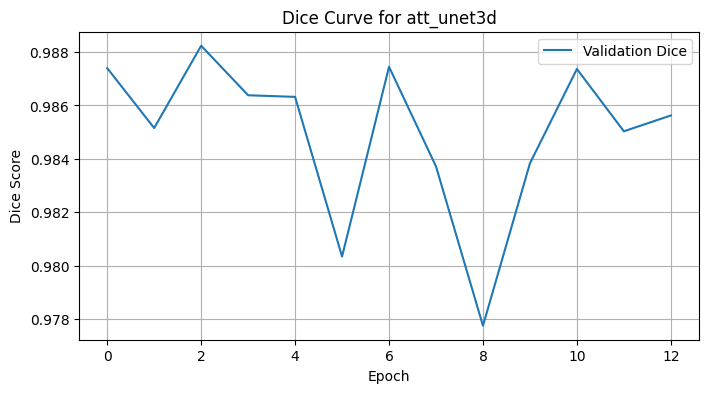

In [12]:
att_unet = AttentionUNet3D()
train_model(att_unet, train_loader, val_loader, name="att_unet3d")

## 📊 Ensemble Prediction and Visualization
 This combines predictions from U-Net and Attention U-Net, averages the logits, and visualizes the ensemble result.

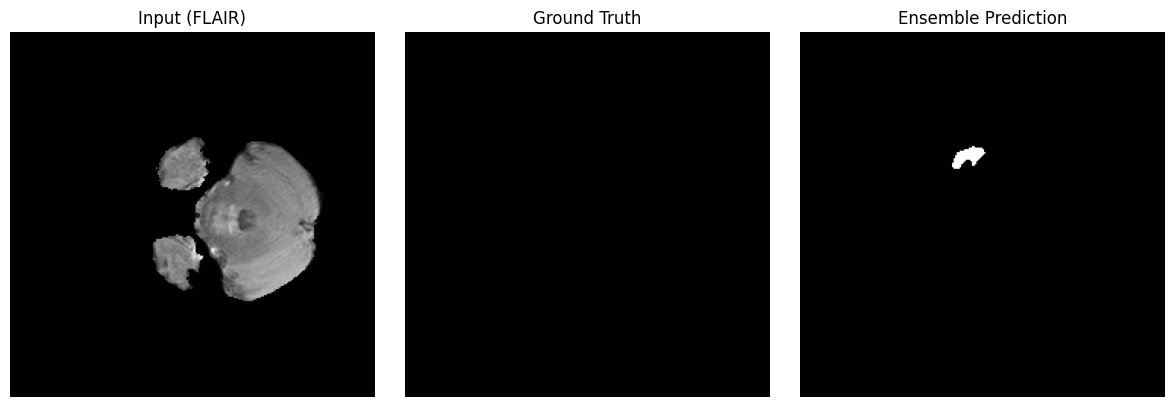

In [10]:
import matplotlib.pyplot as plt

def ensemble_predict(x):
    model1 = UNet3D().to(DEVICE)
    model2 = AttentionUNet3D().to(DEVICE)
    model1.load_state_dict(torch.load("unet3d_best.pth"))
    model2.load_state_dict(torch.load("att_unet3d_best.pth"))
    model1.eval(); model2.eval()

    with torch.no_grad():
        out1 = model1(x)
        out2 = model2(x)
        avg_out = (out1 + out2) / 2
        pred = torch.argmax(avg_out, dim=1)
    return pred

def visualize_ensemble(val_loader):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = ensemble_predict(x)

    mid_slice = x.shape[-1] // 2
    for i in range(min(2, x.shape[0])):  # show 2 examples max
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(x[i][0, :, :, mid_slice].cpu(), cmap='gray')
        plt.title("Input (FLAIR)")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(y[i, :, :, mid_slice].cpu(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred[i, :, :, mid_slice].cpu(), cmap='gray')
        plt.title("Ensemble Prediction")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
visualize_ensemble(val_loader)

# 🔎 Inference and Visualization on a Single Patient

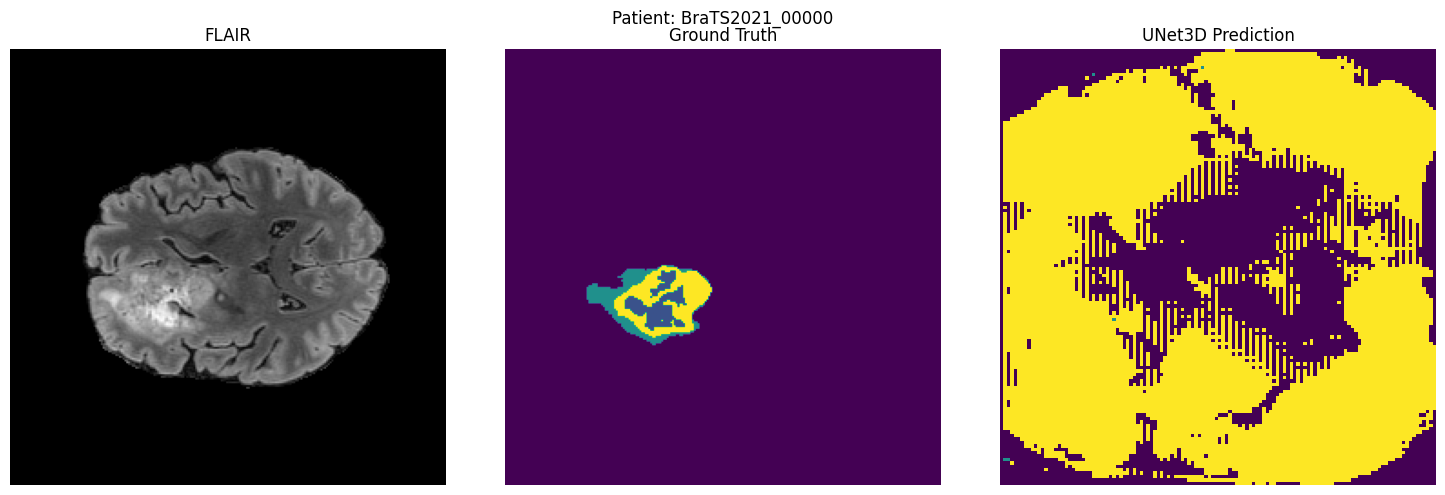

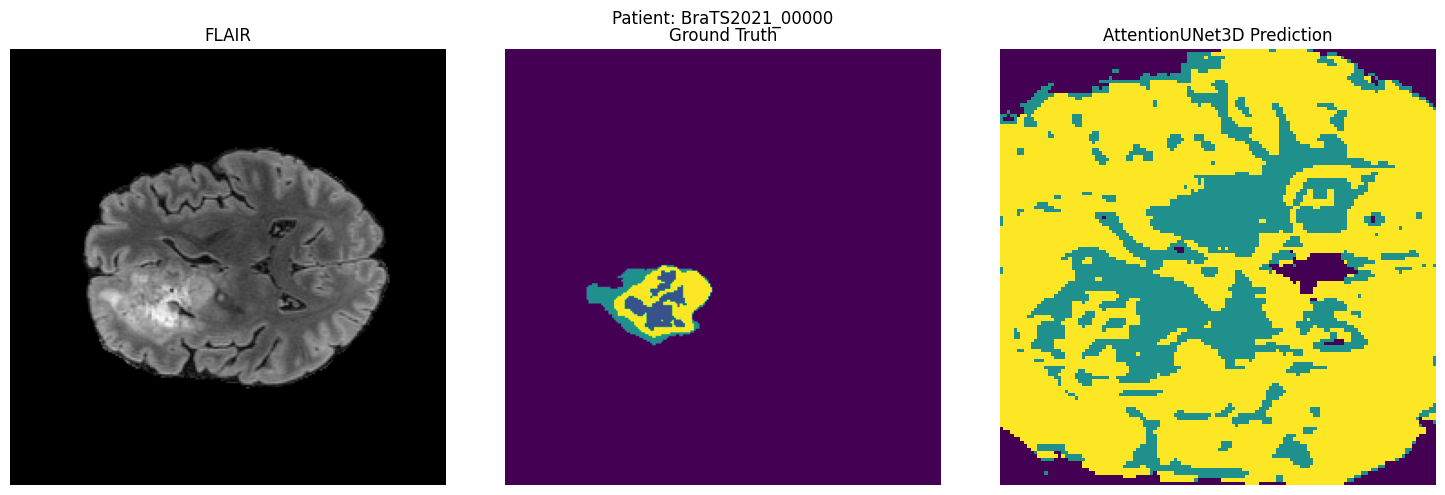

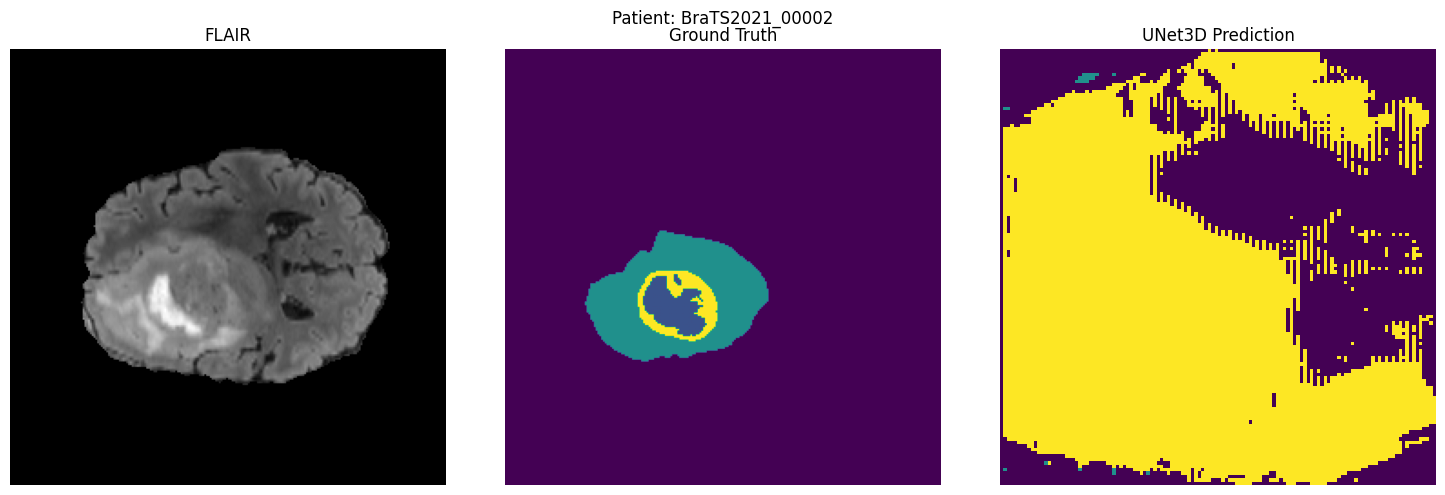

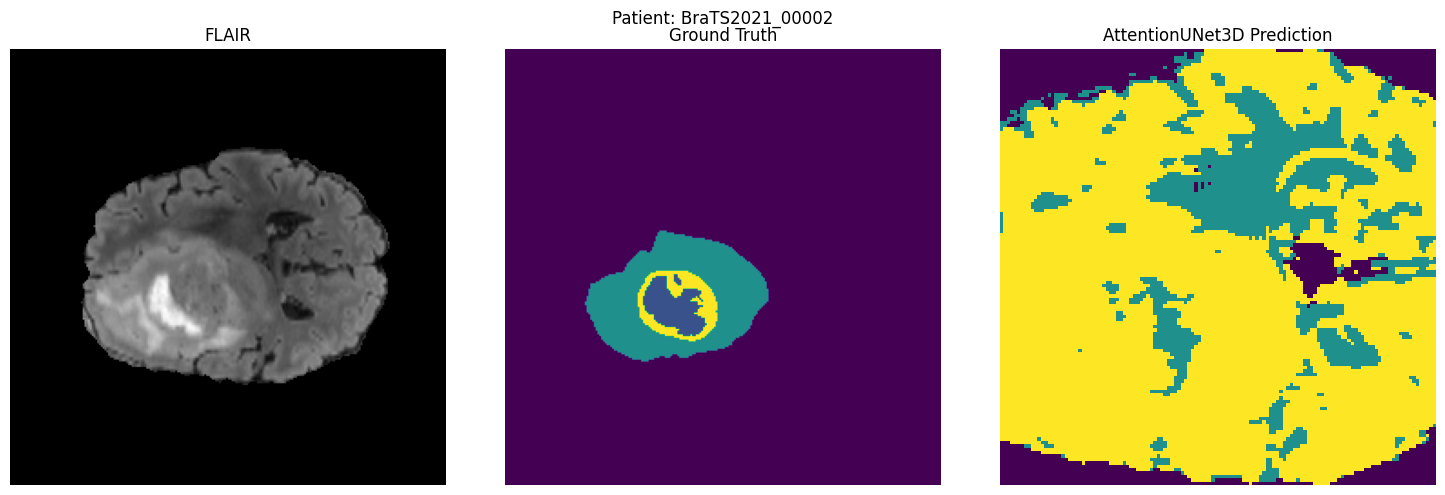

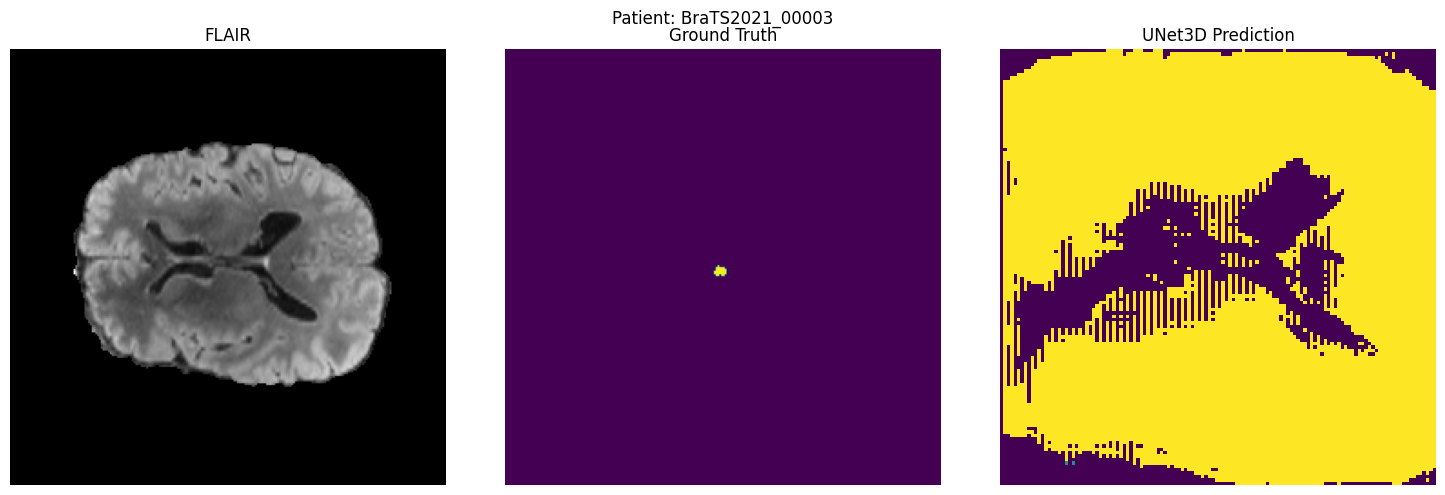

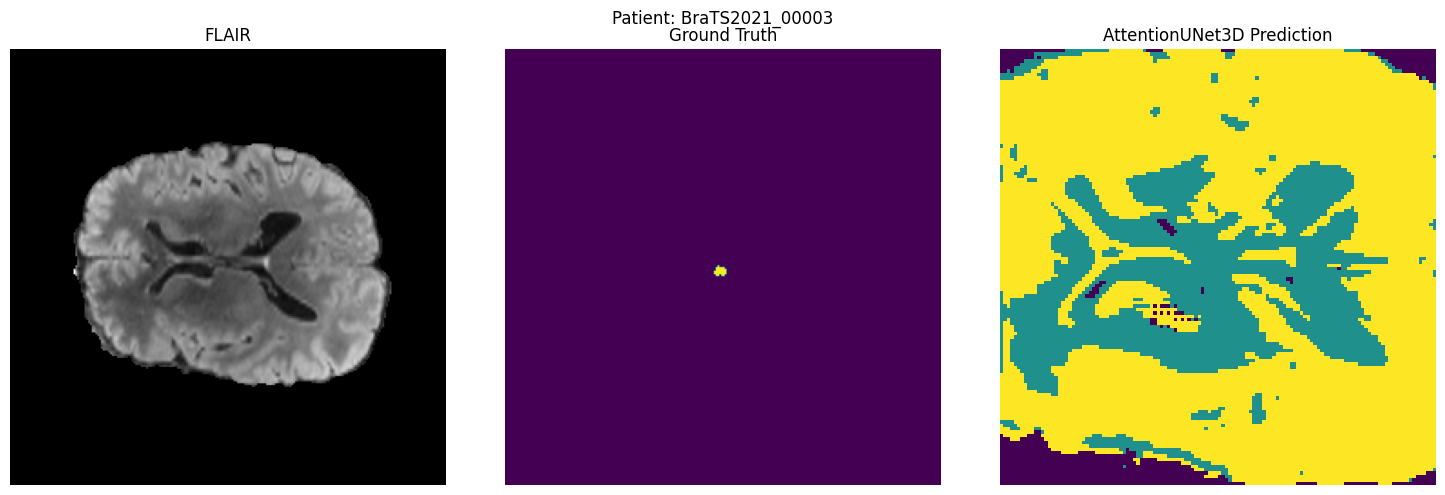

In [23]:
import os
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import numpy as np

def center_crop_or_pad(img, target_shape):
    """
    Center crop or pad a 3D numpy array to the target shape.
    img: shape (..., H, W, D)
    target_shape: tuple (H, W, D)
    """
    out = np.zeros((img.shape[0],) + target_shape, dtype=img.dtype)
    for c in range(img.shape[0]):
        for i in range(3):
            diff = img.shape[i+1] - target_shape[i]
            if diff < 0:
                pad_before = -diff // 2
                pad_after = -diff - pad_before
                slc = [slice(None)] * 4
                slc[i+1] = slice(None)
                out[c] = np.pad(img[c], [(0,0) if j != i else (pad_before, pad_after) for j in range(3)], mode='constant')
            else:
                crop_before = diff // 2
                crop_after = crop_before + target_shape[i]
                slc = [slice(None)] * 4
                slc[i+1] = slice(crop_before, crop_after)
                img = img
        out[c] = img[c, 
                      (img.shape[1] - target_shape[0]) // 2 : (img.shape[1] - target_shape[0]) // 2 + target_shape[0],
                      (img.shape[2] - target_shape[1]) // 2 : (img.shape[2] - target_shape[1]) // 2 + target_shape[1],
                      (img.shape[3] - target_shape[2]) // 2 : (img.shape[3] - target_shape[2]) // 2 + target_shape[2]
                     ]
    return out

def run_inference_on_patient(patient_dir, model_path, model_class, input_shape=(4, 128, 128, 64)):
    flair = nib.load(os.path.join(patient_dir, os.path.basename(patient_dir) + "_flair.nii.gz")).get_fdata()
    t1 = nib.load(os.path.join(patient_dir, os.path.basename(patient_dir) + "_t1.nii.gz")).get_fdata()
    t1ce = nib.load(os.path.join(patient_dir, os.path.basename(patient_dir) + "_t1ce.nii.gz")).get_fdata()
    t2 = nib.load(os.path.join(patient_dir, os.path.basename(patient_dir) + "_t2.nii.gz")).get_fdata()
    
    image = np.stack([flair, t1, t1ce, t2], axis=0).astype(np.float32)
    image = center_crop_or_pad(image, input_shape[1:])
    image = torch.tensor(image).unsqueeze(0).to(DEVICE)
    
    model = model_class().to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    with torch.no_grad():
        output = model(image)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    
    return prediction

def visualize_and_save(patient_dir, prediction, model_name):
    flair_path = os.path.join(patient_dir, os.path.basename(patient_dir) + "_flair.nii.gz")
    gt_path = os.path.join(patient_dir, os.path.basename(patient_dir) + "_seg.nii.gz")
    
    flair = nib.load(flair_path).get_fdata()
    gt = nib.load(gt_path).get_fdata()
    
    # Use the prediction's depth for mid_slice
    mid_slice = prediction.shape[-1] // 2

    # Safely get the same slice from flair and gt (centered)
    def get_center_slice(arr):
        d = arr.shape[-1]
        start = max(0, (d - prediction.shape[-1]) // 2)
        end = start + prediction.shape[-1]
        arr_cropped = arr[..., start:end]
        return arr_cropped

    flair_c = get_center_slice(flair)
    gt_c = get_center_slice(gt)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(flair_c[:, :, mid_slice], cmap='gray')
    axs[0].set_title("FLAIR")
    axs[0].axis("off")

    axs[1].imshow(gt_c[:, :, mid_slice])
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")

    axs[2].imshow(prediction[:, :, mid_slice])
    axs[2].set_title(f"{model_name} Prediction")
    axs[2].axis("off")
    
    plt.suptitle(f"Patient: {os.path.basename(patient_dir)}")
    plt.tight_layout()
    plt.savefig(f"pred_{model_name}_{os.path.basename(patient_dir)}.png")
    plt.show()

# 🔄 Loop over multiple patients
data_root = "C:\\Users\\amira\\Downloads\\BraTS2021_Training_Data"
patient_dirs = sorted([os.path.join(data_root, d) for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d))])

# Only test on 3 for now
for patient_dir in patient_dirs[:3]:
    pred = run_inference_on_patient(patient_dir, "unet3d_best.pth", UNet3D)
    visualize_and_save(patient_dir, pred, "UNet3D")

    pred_att = run_inference_on_patient(patient_dir, "att_unet3d_best.pth", AttentionUNet3D)
    visualize_and_save(patient_dir, pred_att, "AttentionUNet3D")


## Export to TorchScript & ONNX
This cell lets you export both U-Net and Attention U-Net models for deployment (in PyTorch or external tools like TensorRT or ONNX Runtime).

✅ unet3d.pt and att_unet3d.pt → usable in PyTorch mobile or C++ inference

✅ unet3d.onnx and att_unet3d.onnx → compatible with ONNX Runtime, TensorRT, OpenVINO, etc.

In [24]:
import torch.onnx

def export_model(model_class, weight_path, name="unet3d", input_shape=(1, 4, 128, 128, 64)):
    model = model_class().to(DEVICE)
    model.load_state_dict(torch.load(weight_path))
    model.eval()

    dummy_input = torch.randn(input_shape).to(DEVICE)

    # ✅ Export to TorchScript
    traced = torch.jit.trace(model, dummy_input)
    traced.save(f"{name}.pt")
    print(f"✅ TorchScript saved: {name}.pt")

    # ✅ Export to ONNX
    torch.onnx.export(
        model,
        dummy_input,
        f"{name}.onnx",
        export_params=True,
        opset_version=14,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch'}, 'output': {0: 'batch'}},
        do_constant_folding=True
    )
    print(f"✅ ONNX saved: {name}.onnx")

# Export both models
export_model(UNet3D, "unet3d_best.pth", name="unet3d")
export_model(AttentionUNet3D, "att_unet3d_best.pth", name="att_unet3d")


✅ TorchScript saved: unet3d.pt
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

✅ ONNX saved: unet3d.onnx
✅ TorchScript saved: att_unet3d.pt
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

✅ ONNX saved: att_unet3d.onnx


#  Dice Score & Loss Tracking Plot
We’ll modify the training function slightly to return per-epoch loss and Dice values, and then plot them separately.

In [11]:
def train_model(model, train_loader, val_loader, name, epochs=100):
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    criterion = torch.nn.CrossEntropyLoss()
    scaler = GradScaler()
    best_dice = 0
    patience = 10
    trigger = 0

    history = {
        "train_loss": [],
        "val_dice": []
    }

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for x, y in tqdm(train_loader, desc=f"[{name}] Epoch {epoch}"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            with autocast():
                out = model(x)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        model.eval()
        dice = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                with autocast():
                    pred = torch.argmax(model(x), dim=1)
                dice += dice_coeff(pred.cpu(), y.cpu())

        avg_dice = dice / len(val_loader)
        history["train_loss"].append(total_loss)
        history["val_dice"].append(avg_dice.item())

        print(f"Epoch {epoch} | Loss: {total_loss:.4f} | Val Dice: {avg_dice:.4f}")
        scheduler.step(total_loss)

        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), f"{name}_best.pth")
            print(f"✅ Saved best model with Dice: {best_dice:.4f}")
            trigger = 0
        else:
            trigger += 1
            if trigger >= patience:
                print("⏹️ Early stopping triggered.")
                break

    return history

def plot_history(history, title="Training History"):
    epochs = list(range(1, len(history["train_loss"]) + 1))
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_dice"], label="Val Dice", marker="x")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.grid(True)
    plt.legend()
    plt.show()



In [12]:
import torch.nn as nn

class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=5):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True)
            )
        self.enc1 = block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.bottleneck = block(64, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, 2)
        self.dec2 = block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, 2)
        self.dec1 = block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out_conv(d1)

class AttentionBlock3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv3d(F_g, F_int, 1), nn.BatchNorm3d(F_int))
        self.W_x = nn.Sequential(nn.Conv3d(F_l, F_int, 1), nn.BatchNorm3d(F_int))
        self.psi = nn.Sequential(nn.Conv3d(F_int, 1, 1), nn.BatchNorm3d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        return x * self.psi(self.relu(self.W_g(g) + self.W_x(x)))

class AttentionUNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=5):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, 3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True)
            )
        self.enc1 = block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.bottleneck = block(64, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, 2)
        self.att2 = AttentionBlock3D(64, 64, 32)
        self.dec2 = block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, 2)
        self.att1 = AttentionBlock3D(32, 32, 16)
        self.dec1 = block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.att2(self.up2(b), e2)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.att1(self.up1(d2), e1)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return self.out_conv(d1)


In [ ]:
history_unet = train_model(UNet3D(), train_loader, val_loader, name="unet3d", epochs=50)
plot_history(history_unet, title="U-Net 3D")

history_attn = train_model(AttentionUNet3D(), train_loader, val_loader, name="att_unet3d", epochs=50)
plot_history(history_attn, title="Attention U-Net 3D")

[unet3d] Epoch 1:   7%|▋         | 426/5741 [03:00<51:06,  1.73it/s]

# Inference on a New .nii.gz Patient
This lets you run inference on a single new BraTS-format patient folder and visualize the middle slice result.


In [ ]:
import nibabel as nib
import numpy as np
import torch

def run_inference_on_patient(patient_dir, model_path, model_class, patch_depth=64):
    flair = nib.load(os.path.join(patient_dir, os.path.basename(patient_dir) + "_flair.nii.gz")).get_fdata()
    t1 = nib.load(os.path.join(patient_dir, os.path.basename(patient_dir) + "_t1.nii.gz")).get_fdata()
    t1ce = nib.load(os.path.join(patient_dir, os.path.basename(patient_dir) + "_t1ce.nii.gz")).get_fdata()
    t2 = nib.load(os.path.join(patient_dir, os.path.basename(patient_dir) + "_t2.nii.gz")).get_fdata()

    # Stack channels: (4, H, W, D)
    image = np.stack([flair, t1, t1ce, t2], axis=0).astype(np.float32)
    image = torch.tensor(image).unsqueeze(0).to(DEVICE)  # (1, 4, H, W, D)

    model = model_class().to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        output = model(image)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    return prediction  # shape: (H, W, D)

# 🔍 Visualization:
import matplotlib.pyplot as plt

def visualize_patient_prediction(patient_dir, prediction):
    flair_path = os.path.join(patient_dir, os.path.basename(patient_dir) + "_flair.nii.gz")
    flair = nib.load(flair_path).get_fdata()

    mid_slice = flair.shape[-1] // 2
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(flair[:, :, mid_slice], cmap='gray')
    plt.title("FLAIR Input")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(prediction[:, :, mid_slice], cmap='gray')
    plt.title("Predicted Segmentation")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# Inference on a single new patient folder
new_patient = r"D:\BraTS2021_Training_Data\BraTS2021_00005"  # replace with your path
pred = run_inference_on_patient(new_patient, "unet3d_best.pth", UNet3D)
visualize_patient_prediction(new_patient, pred)


# 💾 Save Predicted Mask as .nii.gz

This is useful when you want to visualize or process the segmentation result in tools like 3D Slicer, ITK-SNAP, or use for clinical post-processing.

In [ ]:
def save_prediction_as_nifti(prediction, reference_nifti_path, output_path):
    """
    Saves a 3D numpy array (prediction) as a .nii.gz file using the affine and header from a reference image.
    """
    reference_nifti = nib.load(reference_nifti_path)
    pred_nifti = nib.Nifti1Image(prediction.astype(np.uint8), affine=reference_nifti.affine, header=reference_nifti.header)
    nib.save(pred_nifti, output_path)
    print(f"✅ Saved predicted mask as: {output_path}")


# Assuming you already have `pred` from the previous inference
ref_img_path = os.path.join(new_patient, os.path.basename(new_patient) + "_flair.nii.gz")
output_path = "BraTS2021_00005_predicted_mask.nii.gz"

save_prediction_as_nifti(pred, ref_img_path, output_path)


# Class Distribution Analysis
This helps you analyze label imbalance across the segmentation masks, which is common in medical datasets like BraTS (e.g., large background, small tumor).

In [ ]:
# 📊 Function to Analyze Label Frequencies:
import numpy as np
import matplotlib.pyplot as plt

def analyze_class_distribution(dataset, num_classes=4):
    class_counts = np.zeros(num_classes)

    for i in range(min(100, len(dataset))):  # analyze first 100 samples to save RAM
        _, mask = dataset[i]
        unique, counts = np.unique(mask.numpy(), return_counts=True)
        for u, c in zip(unique, counts):
            if u < num_classes:
                class_counts[int(u)] += c

    total = class_counts.sum()
    percentages = 100 * class_counts / total

    for cls in range(num_classes):
        print(f"Class {cls}: {int(class_counts[cls])} voxels ({percentages[cls]:.2f}%)")

    plt.figure(figsize=(6, 4))
    plt.bar(range(num_classes), percentages)
    plt.xticks(range(num_classes))
    plt.title("Class Distribution (%)")
    plt.xlabel("Class Label")
    plt.ylabel("Percentage")
    plt.grid(True)
    plt.show()


# Model Summary with torchinfo
This helps visualize the architecture, layer-wise output shapes, and parameter counts for each model. Very useful for documentation and debugging.

In [ ]:
from torchinfo import summary

def show_model_summary(model_class, input_shape=(1, 4, 128, 128, 64), name="Model"):
    print(f"\n📊 Summary for {name}")
    model = model_class().to(DEVICE)
    summary(model, input_size=input_shape, depth=3, col_names=["input_size", "output_size", "num_params"])
    
show_model_summary(UNet3D, name="U-Net 3D")
show_model_summary(AttentionUNet3D, name="Attention U-Net 3D")



## ✅ Summary & Deployment Tips
- Best Dice model saved as `.pth`
- Deployment-ready formats: `.pt` (TorchScript), `.onnx`
- Use ONNX for ONNX Runtime, TensorRT, or OpenVINO.
- Ideal for mobile, embedded, or web deployment.

**Next step:** Try converting the ONNX model into TensorRT or integrating in a simple Flask demo.